# Benchmarking

In [1]:
# Change working directory to parent so we can import as we would from main.py
%cd ..

import pandas as pd
import configuration as config
import functions.plotting as plot_funcs

/mnt/arkk/llm_detector/llm_detector_benchmarking


## 1. Model loading time
### 1.1. TLDR
1. Low 11 seconds is the fastest we can load: 16 CPU cores, GTX1070, NFS RAID5. 
2. Factor importance: CPU cores (tens of seconds) > device (a few seconds) > source drive (tenths or hundredths of seconds)

In [2]:
# Load the data
time_df=pd.read_json(f'{config.BENCHMARKING_DATA_PATH}/model_loading_benchmark.json')

# Format/translate values and column names for pretty printing in plot

# Dictionary of variable values their replacements
value_translation_dict={
    '/mnt/ramdisk/huggingface_transformers_cache': 'Ramdisk',
    '/mnt/fast_scratch/huggingface_transformers_cache': 'NVMe SSD',
    '/mnt/arkk/huggingface_transformers_cache': 'NFS RAID5',
    '/home/siderealyear/huggingface_transformers_cache': 'SATA SSD',
    'cuda:0': 'GTX1070',
    'cuda:1': 'Tesla K80',
    'sequential': 'Multi-GPU, sequential',
    'auto': 'Mixed GPU/CPU',
    'cpu': 'CPU only'
}

# Dictionary of column names and their replacement values
column_name_translation_dict={
    'load_time': 'Load time (sec.)',
    'device_map': 'Device map',
    'cache_dir': 'Cache location',
    'cpu_cores': 'CPU cores',
    'iteration': 'Replicate'
}

time_df=plot_funcs.replace_strings(
    time_df, 
    value_translation_dict, 
    column_name_translation_dict
)

# Remove an outlier above 2 minutes from one iteration
# of the NFS RAID5 trial - probably some kind of network
# hiccup and not really representative of the true speed.
time_df=time_df[time_df['Load time (sec.)'] < 120]

# Add a feature for model loading rate with units of per second
# so that 'higher is better' consistent with rate plots below
time_df['Load rate (Hz)']=1 / time_df['Load time (sec.)']


### 1.2. Model loading time plot

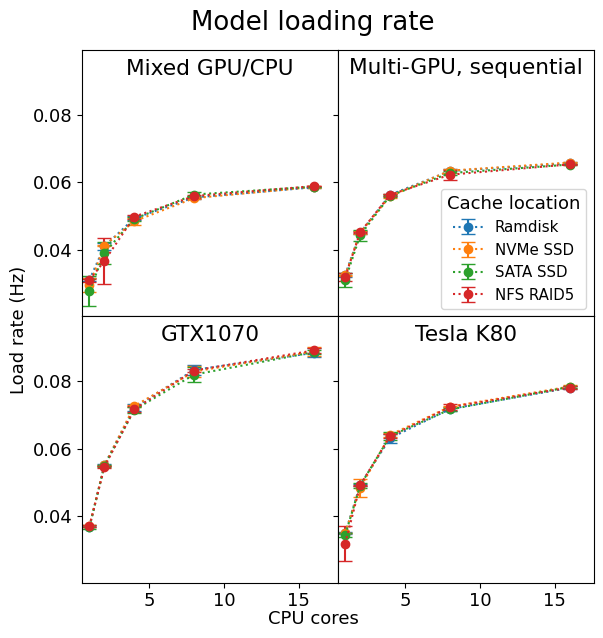

In [3]:
plot_funcs.multipanel_error_bar_two_factors(
    figure_title='Model loading rate',
    data=time_df,
    exclusions={'Device map': ['CPU only']},
    panel_factor='Device map',
    series_factor='Cache location',
    independent_var='CPU cores',
    dependent_var='Load rate (Hz)',
    legend_loc='lower right'
).show()

### 1.3. Model loading time averages: 16 CPU cores

In [4]:
max_cpu_cores_df=time_df[time_df['CPU cores'] == 16]

max_cpu_cores_df.groupby(                
    ['Cache location','Device map','CPU cores'],
    as_index=False
)['Load time (sec.)'].mean()

,Cache location,Device map,CPU cores,Load time (sec.)
0,NFS RAID5,CPU only,16,3.205901
1,NFS RAID5,GTX1070,16,11.220834
2,NFS RAID5,Mixed GPU/CPU,16,17.000996
3,NFS RAID5,"Multi-GPU, sequential",16,15.327093
4,NFS RAID5,Tesla K80,16,12.801541
5,NVMe SSD,CPU only,16,3.180673
6,NVMe SSD,GTX1070,16,11.259291
7,NVMe SSD,Mixed GPU/CPU,16,17.077475
8,NVMe SSD,"Multi-GPU, sequential",16,15.202062
9,NVMe SSD,Tesla K80,16,12.753425


### 1.4. Observations
1. Loading the model onto a single GPU is fastest overall and the GTX1070 beats the K80 by 0.5 - 1.5 seconds. Interestingly, this difference gets slightly larger when more CPU core are used. Note: in reality, loading the model onto CPU only is ~3-4x faster, but inference on CPU is so slow (~10x slower) to make the fast loading time pretty much irrelevant. Unless, maybe if we are optimizing something that necessitates loading the model over and over for a quick task.
2. CPU core count matters for all device maps tested, but after ~8 cores, there is not much benefit to adding more.
3. The cache location does not make a large difference in the loading time. It appears that loading from the NVMe SSD or ramdisk is a little more consistent than loading from the NFS RAID5 or the SATA SSD. This is likely because the SATA SSD is the system boot disk and the NFS RAID5 is a network share. Both of these disks are doing other things concurrent with model loading, while the NVMe SSD is a dedicated fast scratch drive and the ramdisk was created and mounted for the express purpose of this benchmark.

### 1.5. Conclusions
1. The fastest possible model loading rate is achieved using 16 CPU cores to load onto the CPU from a ramdisk.
2. If the CPU only device map is excluded due to low inference rate, then the GTX1070 wins.
3. Use 4-8 CPU cores when loading the model if possible. 
4. It doesn't much matter where the model is loaded from, but it's best to load it from a dedicated drive, if possible.

## 2. Generation rate

### 2.1. TLDR
1. Winner
2. Factor importance rank

In [5]:
# Load data
rate_df=pd.read_json(f'{config.BENCHMARKING_DATA_PATH}/generation_rate_benchmark.json')

# Format/translate values and column names for pretty printing in plot

# Dictionary of variable values their replacements
value_translation_dict={
    'cuda:0': 'GTX1070',
    'cuda:1': 'Tesla K80',
    'sequential': 'Multi-GPU, sequential',
    'auto': 'Mixed GPU/CPU',
    'cpu': 'CPU only'
}

# Dictionary of column names and their replacement values
column_name_translation_dict={
    'quantization': 'Quantization',
    'device_map': 'Device map',
    'cpu_cores': 'CPU cores',
    'max_new_tokens': 'Max new tokens',
    'tokens_generated': 'Tokens generated',
    'inference_time': 'Inference time (sec.)',
    'generation_rate': 'Generation rate (tokens per sec.)',
    'iteration': 'Replicate'
}

# Do the replacement
rate_df=plot_funcs.replace_strings(
    rate_df, 
    value_translation_dict, 
    column_name_translation_dict
)

# Convert string 'OOM' and 'NAN' to np.nan
rate_df=plot_funcs.clean_nan_oom(rate_df)

# Drop rows with np.nan
rate_df.dropna(inplace=True)

### 2.2. Generation rate: 4-bit vs 8-bit quantization by device

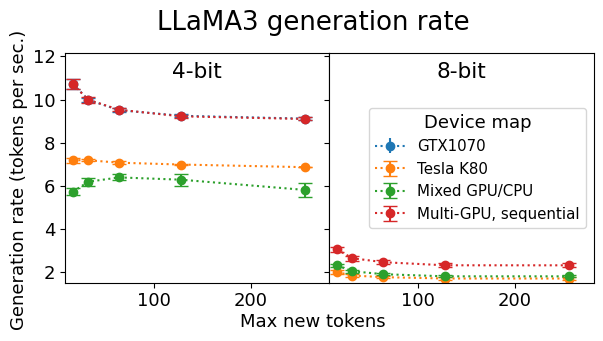

In [6]:
plot_funcs.multipanel_error_bar_two_factors(
    figure_title='LLaMA3 generation rate',
    data=rate_df,
    plot_rows=1,
    plot_cols=2,
    exclusions={'Device map': ['CPU only']},
    panel_factor='Quantization',
    series_factor='Device map',
    independent_var='Max new tokens',
    dependent_var='Generation rate (tokens per sec.)',
    legend_loc='center right'
).show()

### 2.3. Generation rate: 4-bit quantization by device and CPU cores

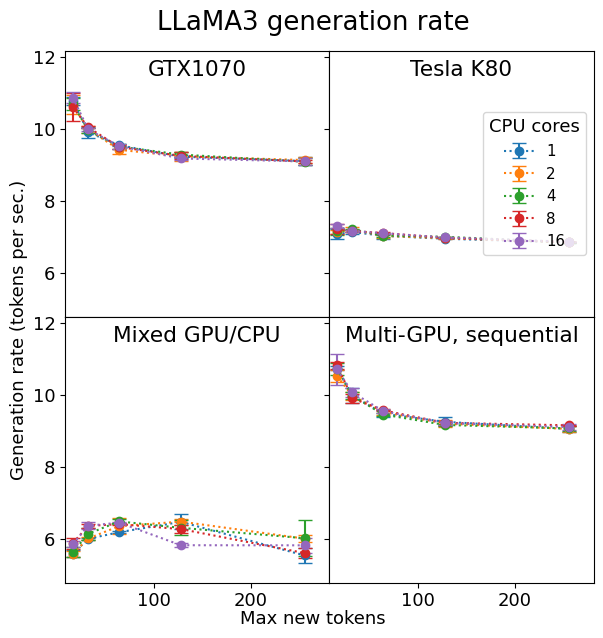

In [7]:
plot_funcs.multipanel_error_bar_two_factors(
    figure_title='LLaMA3 generation rate',
    data=rate_df,
    exclusions={'Quantization': ['8-bit'], 'Device map': ['CPU only']},
    panel_factor='Device map',
    series_factor='CPU cores',
    independent_var='Max new tokens',
    dependent_var='Generation rate (tokens per sec.)',
    legend_loc='center right'
).show()

### 2.4. Generation rate: CPU only by CPU cores

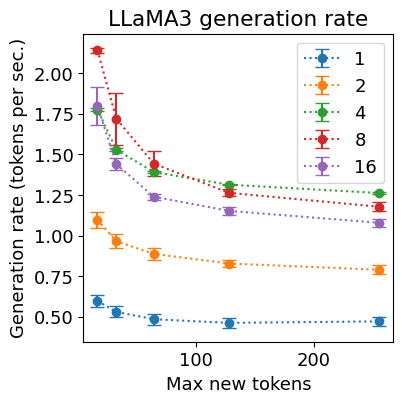

In [8]:
plot_funcs.single_errorbar(
    figure_title='LLaMA3 generation rate',
    data=rate_df[rate_df['Device map'] == 'CPU only'],
    series_factor='CPU cores',
    independent_var='Max new tokens',
    dependent_var='Generation rate (tokens per sec.)'
).show()

### 2.5. Generation rate averages: 256 tokens, 4 CPU cores

In [9]:
large_output_df=rate_df[(rate_df['Max new tokens'] == 256) & (rate_df['CPU cores'] == 4)]

large_output_df.groupby(                
    ['Quantization','Device map'],
    as_index=False
)['Inference time (sec.)'].mean()

,Quantization,Device map,Inference time (sec.)
0,4-bit,CPU only,210.586877
1,4-bit,GTX1070,29.257907
2,4-bit,Mixed GPU/CPU,44.411048
3,4-bit,"Multi-GPU, sequential",29.311408
4,4-bit,Tesla K80,38.849109
5,8-bit,CPU only,211.113656
6,8-bit,Mixed GPU/CPU,75.292440
7,8-bit,"Multi-GPU, sequential",58.260855
8,8-bit,Tesla K80,79.726298


### 2.6. Observations
1. Inference is almost 5x faster when the model is loaded in 4-bit vs 8-bit.
2. The GTX1070 fails due to out-of-memory when trying to load the 8-bit quantized model. The K80 and the multi-GPU sequential device map can handel it.
3. The GTX1070 is fastest overall, but it beats the multi-GPU sequential device map by only a few hundredths of a second.
4. Setting larger *max_new_tokens* during generation generally slows the model down.
5. The number of CPU cores available has little to no effect.
6. The mixed GPU/CPU device map initially speeds up slightly as *max_new_tokens* increases and then slows down again.
7. The Tesla K80 is not effected by *max_new_tokens* nearly as much as the GTX1070. The GTX1070's generation rate drops ~15% while the K80's only decreases only ~4.5% over the same 4 doublings of *max_new_tokens*. Also the K80's decrease looks almost linear, while the GTX1070's looks much more like exponential decay and will never slow down enough to meet the K80, no matter how large *max_new_tokens* gets.

### 2.7. Conclusions
1. Fastest possible time to generate 256 tokens from a cold start is 12 sec. loading time + 29 sec. inference time = 41 sec. 
2. Best overall configuration so far is to load the 4-bit quantized model from a ramdisk or the NVMe SSD onto the GTX1070 using 8 CPU cores.
1. The fastest generation rate is achieved with the GTX1070 and a *max_new_tokens* size of 16.
2. Use the GTX1070 where possible for the fastest single model runs, but in situations were multiple models can be run in parallel using both of the K80's chips will give an ~35% faster 'net' training rate over the single chip on the GTX1070.
3. Use 4-8 CPU cores for where possible for the sake of model loading speed.

### 2.8. Decoding strategy

In [10]:
rate_df=pd.read_json(f'{config.BENCHMARKING_DATA_PATH}/decoding_strategy_benchmark.json')

# Format/translate values and column names for pretty printing in plot

# Dictionary of variable values their replacements
value_translation_dict={
    'cuda:0': 'GTX1070',
    'cuda:1': 'Tesla K80'
}

# Dictionary of column names and their replacement values
column_name_translation_dict={
    'quantization': 'Quantization',
    'device_map': 'Device map',
    'cpu_cores': 'CPU cores',
    'max_new_tokens': 'Max new tokens',
    'decoding_strategy': 'Decoding strategy',
    'tokens_generated': 'Tokens generated',
    'inference_time': 'Inference time (sec.)',
    'generation_rate': 'Generation rate (tokens per sec.)',
    'iteration': 'Replicate'
}

# Do the replacement
rate_df=plot_funcs.replace_strings(
    rate_df, 
    value_translation_dict, 
    column_name_translation_dict
)

# Convert string 'OOM' and 'NAN' to np.nan
rate_df=plot_funcs.clean_nan_oom(rate_df)

# Drop rows with np.nan
rate_df.dropna(inplace=True)

### 2.9. Generation rate: decoding strategy, K80 vs GTX1070

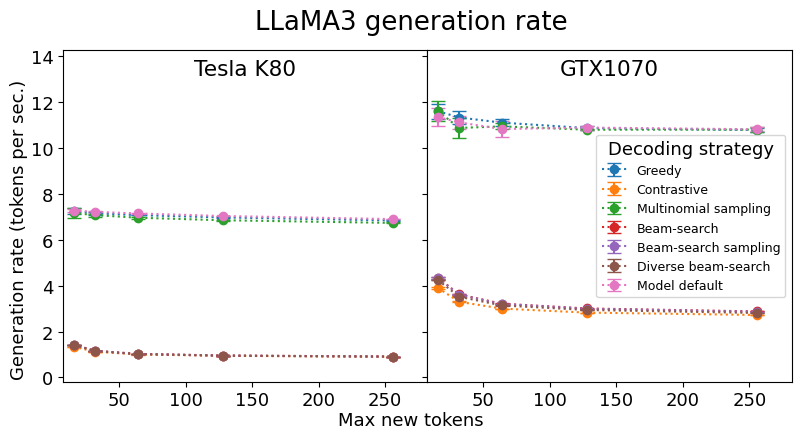

In [11]:
plot_funcs.multipanel_error_bar_two_factors(
    figure_title='LLaMA3 generation rate',
    data=rate_df,
    y_axis_extra_pad=1.0,
    plot_rows=1,
    plot_cols=2,
    plot_width=4,
    plot_height=4,
    panel_factor='Device map',
    series_factor='Decoding strategy',
    independent_var='Max new tokens',
    dependent_var='Generation rate (tokens per sec.)',
    legend_loc='center right',
    legend_font='x-small'
).show()

### 2.10. Inference time averages: 256 tokens

In [12]:
large_output_df=rate_df[rate_df['Max new tokens'] == 256]

large_output_df.groupby(                
    ['Decoding strategy','Device map'],
    as_index=False
)['Inference time (sec.)'].mean()

,Decoding strategy,Device map,Inference time (sec.)
0,Beam-search,GTX1070,92.554560
1,Beam-search,Tesla K80,291.820342
2,Beam-search sampling,GTX1070,93.026795
3,Beam-search sampling,Tesla K80,292.602704
4,Contrastive,GTX1070,97.805991
5,Contrastive,Tesla K80,294.849243
6,Diverse beam-search,GTX1070,94.751384
7,Diverse beam-search,Tesla K80,294.002484
8,Greedy,GTX1070,24.687998
9,Greedy,Tesla K80,38.922538


### 2.11. Observations
1. 

### 2.12. Conclusions
1. 

## 3. Logits calculation

### 3.1. TLDR
1. Winner
2. Factor importance rank

In [13]:
memory_df=pd.read_json(f'{config.BENCHMARKING_DATA_PATH}/logits_memory_benchmark.json')

# Format/translate values and column names for pretty printing in plot

# Dictionary of variable values their replacements
value_translation_dict={
    'cuda:0': 'GTX1070',
    'cuda:1': 'Tesla K80',
    'sequential': 'Multi-GPU, sequential',
    'auto': 'Mixed GPU/CPU',
    'meta-llama/Meta-Llama-3-8B': 'LLaMA3-8B',
    'tiiuae/falcon-7b': 'Falcon-7B',
    'meta-llama/Llama-2-7b-hf': 'LLaMA2-7B',
    'mistralai/Mistral-7B-v0.3': 'Mistral-7B'
}

# Dictionary of column names and their replacement values
column_name_translation_dict={
    'hf_model_string': 'Model',
    'peak_memory': 'Peak memory (GB)',
    'tokens': 'Encoded length (tokens)',
    'logits_time': 'Logit calculation time (sec.)',
    'rate': 'Logit calculation rate (tokens per sec.)',
    'input_length': 'Input length (words)',
    'device_map': 'Device map',
    'iteration': 'Replicate'
}

# Do the replacement
memory_df=plot_funcs.replace_strings(
    memory_df, 
    value_translation_dict, 
    column_name_translation_dict
)

# Convert string 'OOM' and 'NAN' to np.nan
memory_df=plot_funcs.clean_nan_oom(memory_df)

# Drop rows with np.nan
memory_df.dropna(inplace=True)

### 3.2. Memory footprint: model, device map & input length

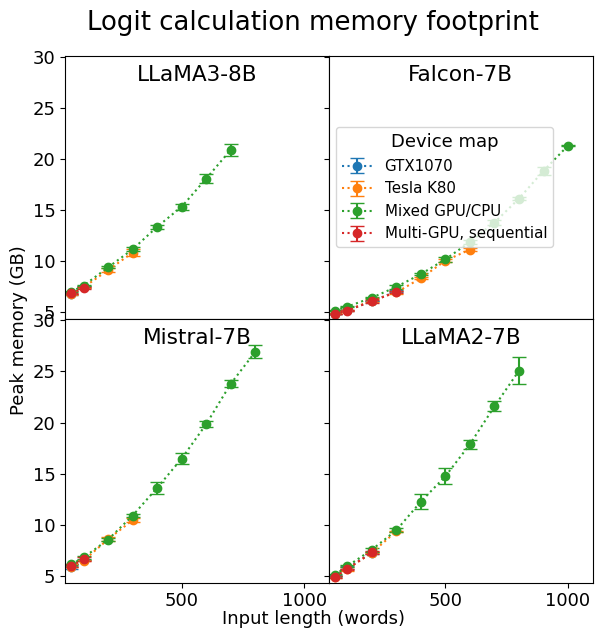

In [14]:
plot_funcs.multipanel_error_bar_two_factors(
    figure_title='Logit calculation memory footprint',
    data=memory_df,
    panel_factor='Model',
    series_factor='Device map',
    independent_var='Input length (words)',
    dependent_var='Peak memory (GB)',
    legend_loc='center left'
).show()

### 3.3. Rate: model, device map & input length

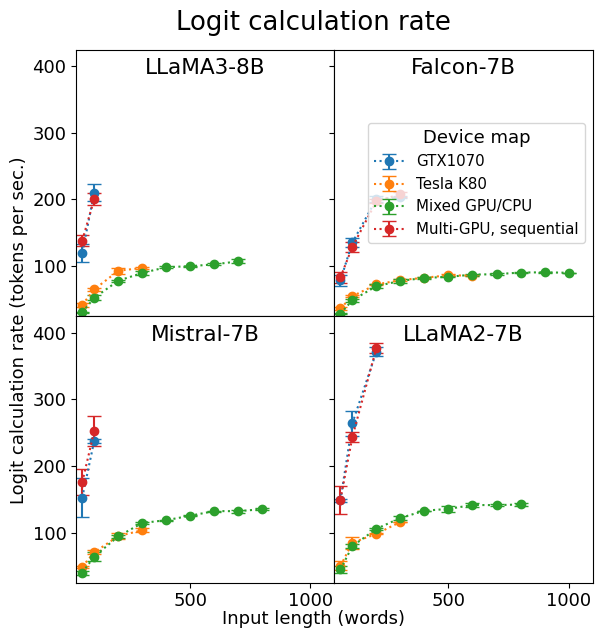

In [15]:
plot_funcs.multipanel_error_bar_two_factors(
    figure_title='Logit calculation rate',
    data=memory_df,
    panel_factor='Model',
    series_factor='Device map',
    independent_var='Input length (words)',
    dependent_var='Logit calculation rate (tokens per sec.)',
    legend_loc='center right'
).show()

### 3.4. Memory: CPU vs GPU

In [16]:
memory_df=pd.read_json(f'{config.BENCHMARKING_DATA_PATH}/logits_cpu_benchmark.json')

# Format/translate values and column names for pretty printing in plot

# Dictionary of variable values their replacements
value_translation_dict={
    'cpu': 'CPU',
    'sequential': 'Multi-GPU',
    'meta-llama/Meta-Llama-3-8B': 'LLaMA3-8B',
    'tiiuae/falcon-7b': 'Falcon-7B',
    'meta-llama/Llama-2-7b-hf': 'LLaMA2-7B',
    'mistralai/Mistral-7B-v0.3': 'Mistral-7B'


}

# Dictionary of column names and their replacement values
column_name_translation_dict={
    'hf_model_string': 'Model',
    'max_memory': 'Max memory (GB)',
    'tokens': 'Encoded length (tokens)',
    'logits_time': 'Logit calculation time (sec.)',
    'rate': 'Logit calculation rate (tokens per sec.)',
    'input_length': 'Input length (words)',
    'device_map': 'Device map',
    'iteration': 'Replicate'
}

# Do the replacement
memory_df=plot_funcs.replace_strings(
    memory_df, 
    value_translation_dict, 
    column_name_translation_dict
)

# Convert string 'OOM' and 'NAN' to np.nan
memory_df=plot_funcs.clean_nan_oom(memory_df)

# Drop rows with np.nan
memory_df.dropna(inplace=True)

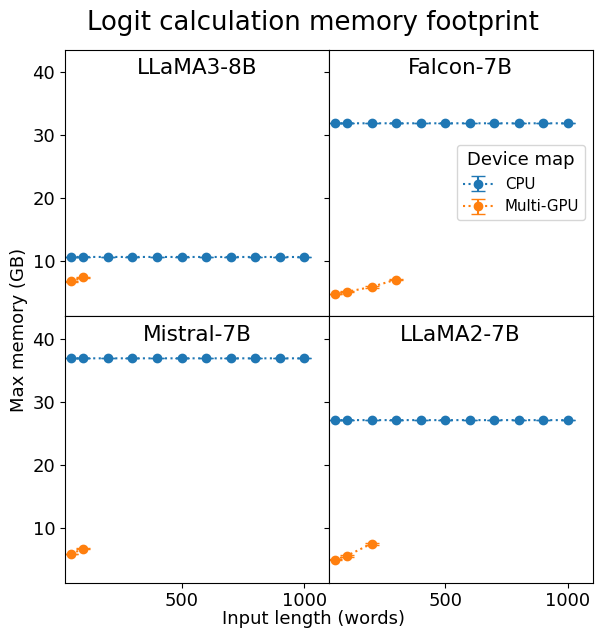

In [17]:
plot_funcs.multipanel_error_bar_two_factors(
    figure_title='Logit calculation memory footprint',
    data=memory_df,
    y_axis_extra_pad=3,
    panel_factor='Model',
    series_factor='Device map',
    independent_var='Input length (words)',
    dependent_var='Max memory (GB)',
    legend_loc='center right'
).show()

### 3.4. Rate: CPU vs GPU

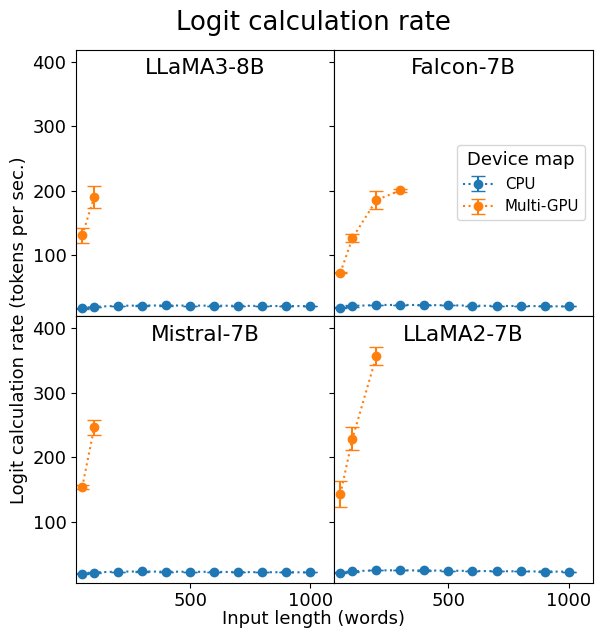

In [18]:
plot_funcs.multipanel_error_bar_two_factors(
    figure_title='Logit calculation rate',
    data=memory_df,
    y_axis_extra_pad=10,
    panel_factor='Model',
    series_factor='Device map',
    independent_var='Input length (words)',
    dependent_var='Logit calculation rate (tokens per sec.)',
    legend_loc='center right'
).show()

## 4. String encoding
### 4.1. TLDR
1. Winner
2. Factor importance rank

In [19]:
memory_df=pd.read_json(f'{config.BENCHMARKING_DATA_PATH}/encoding_memory_benchmark.json')

# Format/translate values and column names for pretty printing in plot

# Dictionary of variable values their replacements
value_translation_dict={
    'cuda:0': 'GTX1070',
    'cuda:1': 'Tesla K80',
    'auto': 'Mixed GPU/CPU',
    'sequential': 'Multi-GPU'
}

# Dictionary of column names and their replacement values
column_name_translation_dict={
    'hf_model_string': 'Model',
    'peak_memory': 'Peak memory (GB)',
    'tokens': 'Encoded length (tokens)',
    'encoding_time': 'Encoding time (sec.)',
    'encoding_rate': 'Encoding rate (tokens per sec.)',
    'input_length': 'Input length (words)',
    'device_map': 'Device map',
    'iteration': 'Replicate'
}

# Do the replacement
memory_df=plot_funcs.replace_strings(
    memory_df, 
    value_translation_dict, 
    column_name_translation_dict
)

# Convert string 'OOM' and 'NAN' to np.nan
memory_df=plot_funcs.clean_nan_oom(memory_df)

# Drop rows with np.nan
memory_df.dropna(inplace=True)

### 4.2. Memory footprint: device map & input sequence length

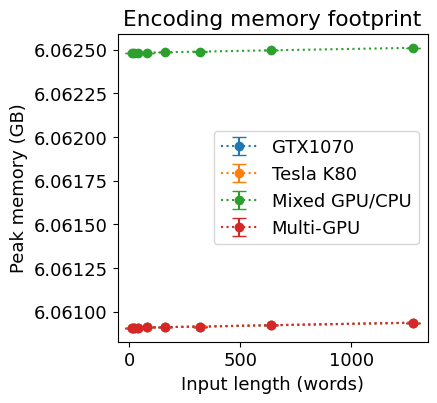

In [20]:
plot_funcs.single_errorbar(
    figure_title='Encoding memory footprint',
    data=memory_df,
    series_factor='Device map',
    independent_var='Input length (words)',
    dependent_var='Peak memory (GB)'
).show()

### 4.3. Encoding rate: device map & input sequence length

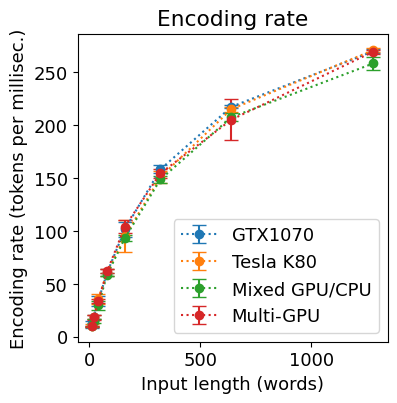

In [21]:
memory_df['Encoding rate (tokens per millisec.)']=memory_df['Encoding rate (tokens per sec.)'] / 1000

plot_funcs.single_errorbar(
    figure_title='Encoding rate',
    data=memory_df,
    series_factor='Device map',
    independent_var='Input length (words)',
    dependent_var='Encoding rate (tokens per millisec.)'
).show()